In [1]:
print("""
@File         : ex9.ipynb
@Author(s)    : Stephen CUI
@LastEditor(s): Stephen CUI
@CreatedTime  : 2024-04-06 19:16:45
@Email        : cuixuanstephen@gmail.com
@Description  : 
""")


@File         : ex9.ipynb
@Author(s)    : Stephen CUI
@LastEditor(s): Stephen CUI
@CreatedTime  : 2024-04-06 19:16:45
@Email        : cuixuanstephen@gmail.com
@Description  : 



1. Use all exogenous variables in the SARIMAX model.
2. Perform residual analysis.
3. Produce forecasts for the last seven timesteps in the dataset.
4. Measure the MAPE. Is it better, worse, or identical to what was achieved with a limited number of exogenous variables?

In [2]:
%cd ../

d:\Time-Series\TSFP


In [3]:
import warnings
from utils.optimize import optimize_SARIMAX
from utils.forecast import rolling_forecast
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
from itertools import product
from sklearn.metrics import mean_absolute_percentage_error

warnings.filterwarnings("ignore")

In [4]:
macro_econ_data = sm.datasets.macrodata.load_pandas().data
target = macro_econ_data["realgdp"]
exog = macro_econ_data[
    [
        "realcons",
        "realinv",
        "realgovt",
        "realdpi",
        "cpi",
        "m1",
        "tbilrate",
        "unemp",
        "pop",
        "infl",
        "realint",
    ]
]

In [5]:
ad_fuller_result = adfuller(target)

print(f"ADF Statistic: {ad_fuller_result[0]}")
print(f"p-value: {ad_fuller_result[1]}")

ADF Statistic: 1.7504627967647166
p-value: 0.9982455372335032


In [6]:
target_diff = np.diff(target, n=1)
ad_fuller_result = adfuller(target_diff[1:])

print(f"ADF Statistic: {ad_fuller_result[0]}")
print(f"p-value: {ad_fuller_result[1]}")

ADF Statistic: -6.3040021851401615
p-value: 3.358129321817665e-08


In [7]:
target_train = target[:200]
exog_train = exog[:200]
p = range(0, 4, 1)
d = 1
q = range(0, 4, 1)
P = range(0, 4, 1)
D = 0
Q = range(0, 4, 1)
s = 4

In [8]:
parameters = product(p, q, P, Q)
parameters_list = list(parameters)
result_df = optimize_SARIMAX(target, exog, parameters_list, d, D, s)
print(result_df)

100%|██████████| 256/256 [08:16<00:00,  1.94s/it]

        (p,q,P,Q)          AIC
0    (3, 3, 2, 2)  1792.700623
1    (3, 3, 2, 3)  1794.252102
2    (3, 3, 3, 2)  1794.383042
3    (0, 0, 2, 2)  1794.611359
4    (2, 2, 0, 0)  1795.688642
..            ...          ...
251  (3, 0, 0, 0)  1808.498461
252  (0, 2, 0, 0)  1808.849747
253  (1, 0, 0, 0)  1809.430815
254  (0, 1, 0, 0)  1809.440247
255  (0, 3, 0, 0)  1810.211631

[256 rows x 2 columns]


In [9]:
best_model = SARIMAX(
    target_train,
    exog_train,
    order=(2, 1, 2),
    seasonal_order=(1, 0, 0, 4),
    simple_differencing=False,
)
best_model_fit = best_model.fit(disp=False)
print(best_model_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                            realgdp   No. Observations:                  200
Model:             SARIMAX(2, 1, 2)x(1, 0, [], 4)   Log Likelihood                -861.521
Date:                            Sat, 06 Apr 2024   AIC                           1757.042
Time:                                    19:36:12   BIC                           1813.028
Sample:                                         0   HQIC                          1779.701
                                            - 200                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
realcons       0.9567      0.054     17.620      0.000       0.850       1.063
realinv        0.9968      0.042   

     lb_stat  lb_pvalue
1   0.017378   0.895121
2   0.070423   0.965401
3   0.085446   0.993525
4   0.214295   0.994654
5   0.224725   0.998824
6   0.228603   0.999772
7   0.229295   0.999960
8   0.309824   0.999979
9   0.324445   0.999995
10  0.324709   0.999999


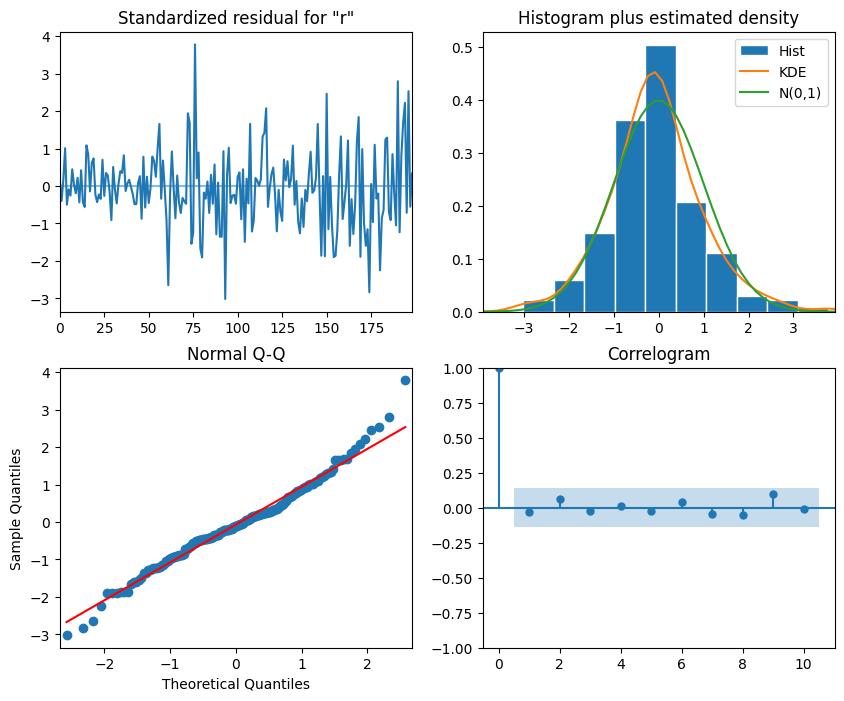

In [10]:
best_model_fit.plot_diagnostics(figsize=(10, 8))
residuals = best_model_fit.resid
lb_result = acorr_ljungbox(residuals, np.arange(1, 11, 1))
print(lb_result)

In [16]:
target_train = target[:196]
target_test = target[196:]
pred_df = pd.DataFrame({"actual": target_test})
TRAIN_LEN = len(target_train)
HORIZON = len(target_test)
WINDOW = 1

pred_last_value = rolling_forecast(target, exog, TRAIN_LEN, HORIZON, WINDOW, "last")
pred_SARIMAX = rolling_forecast(target, exog, TRAIN_LEN, HORIZON, WINDOW, "SARIMAX")
pred_df["pred_last_value"] = pred_last_value
pred_df["pred_SARIMAX"] = pred_SARIMAX

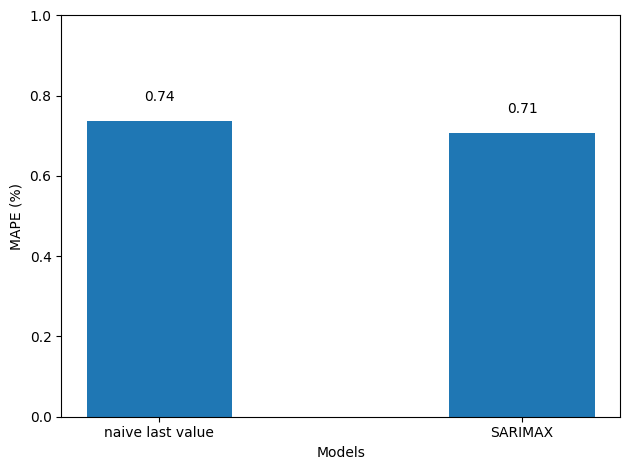

In [17]:
mape_last = 100 * mean_absolute_percentage_error(
    pred_df.actual, pred_df.pred_last_value
)
mape_SARIMAX = 100 * mean_absolute_percentage_error(
    pred_df.actual, pred_df.pred_SARIMAX
)
fig, ax = plt.subplots()

x = ["naive last value", "SARIMAX"]
y = [mape_last, mape_SARIMAX]

ax.bar(x, y, width=0.4)
ax.set_xlabel("Models")
ax.set_ylabel("MAPE (%)")
ax.set_ylim(0, 1)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.05, s=str(round(value, 2)), ha="center")

plt.tight_layout()

没有提高，还变差了